In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import copy
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

For this notebook, the first section is defining and creating the neural network. Then doing CV and Gridsearch on the hyperparameteres.

When we have an optimal parameter combination, we then train on the full training set and perform prediction on the test data

The train and test is in the bottom of the Notebook! To replicate you can use the same as I did. BE AWARE! It might take some time

$\frac{dL}{dZ2}=\frac{2}{m}*(A2-y_{true})$ <- **MSE Gradient**

In [ ]:
""" 
Feed-forward
Get p number of features as input layer neurons. Decicde the number of hidden layers and neurons we have in each.


We use the ReLu function to return, A, which is the new values for input. We randomly init weights for that layer using
HE init. With all the A's we compute a linear combination for the output, from the final hidden layer.

Did the math calculations, the logic and with help of Gemini LLM to implement it using python.
"""

#Reference to hands on ML book page 333.
def he_init(fan_in, fan_out):
    std = np.sqrt(2 / fan_in)
    W = np.random.normal(0, std, size=(fan_out, fan_in))
    return W

class FFNN_regressor:
    def __init__(self, input_size, hidden_layers, seed = None):
        self.seed = seed
        if self.seed is not None:
            np.random.seed(self.seed) 
        if not isinstance(input_size, int):
            raise TypeError(
                "input_size must be an integer (number of features), "
                "not an array, DataFrame, or other type."
            )

        self.input_size = input_size
        self.hidden_layers = hidden_layers
        output_size = 1
        self.weights = {}
        self.bias = {}
        #Creates weight matrix, using HE init. This uses a normal distribution
        #Bias is set to 0 at the start.
        
        for i in range(len(self.hidden_layers)):
            if i == 0:
                in_dim = self.input_size
                out_dim = self.hidden_layers[0]
            else:
                in_dim = self.hidden_layers[i - 1]
                out_dim = self.hidden_layers[i]

            self.weights[f"W{i+1}"] = he_init(in_dim, out_dim).T
            self.bias[f"b{i+1}"] = np.zeros((1, out_dim))

        last_index = len(self.hidden_layers) + 1
        self.weights[f"W{last_index}"] = he_init(self.hidden_layers[-1], output_size).T
        self.bias[f"b{last_index}"] = np.zeros((1,output_size))
        
        #A cache to keep track of the parameters
        self.cache = {}
        self.grad = {}
        
        self.epoch_train_loss = {}
        self.epoch_val_loss = {}
        
    
 

    #Cost function
    def MSE(self, y_true,y_pred):
        cost = ((y_true-y_pred)**2).mean()
        return cost
    #Activation function
    def ReLu(self, Z):
        return np.maximum(0,Z)
    
    def getEpochTL(self):
        return self.epoch_train_loss
    def getEpochVL(self):
        return self.epoch_val_loss
    
    def grad_ReLu(self, Z):
        return (Z>0).astype(float)
    
    #LeakyRelu activation for hidden layers
    def leakyReLu(self,x ,A=0.2):
        return np.where(x < 0, A * x, x)
    
    #LeakyRelu gradient
    def grad_leakyReLu(self, x, A=0.2):
        return np.where(x < 0, A, 1)
    #Forward pass
    def forward_pass(self, X):
        #First A as X/features
        A = X
        #Save A0 as X, for backpropagation: dWi = A^Ti-1 dot dZi
        self.cache["A0"] = X

        L = len(self.weights)
        for i in range(1,L+1):
            W = self.weights[f"W{i}"]
            b = self.bias[f"b{i}"]
            Z = A.dot(W) + b
            self.cache[f"Z{i}"] = Z

            if i != L:
                A = self.leakyReLu(Z)
            else:
                A = Z
            self.cache[f"A{i}"] = A
        return A
# Backward pass with L2 regularization
    def backward(self, y_true, learning_rate = 0.001,lambda_reg = 0.001):
        X= self.cache["A0"]
        y_true = y_true.reshape(-1, 1)
        m = y_true.shape[0]

        L = len(self.weights)
        #Should be the output value.
        A_final = self.cache[f"A{L}"]
        #Initial gradient from MSE loss
        dA = (2/m)*(A_final-y_true)
        #the idea of reserved for loop, was with help of LLM. I didn't know it was a python feature, but very intuitive for backpropagation.5
        for i in reversed(range(1,L+1)):
            #Retrieve cached values

            Z = self.cache[f"Z{i}"]
            A_prev = self.cache[f"A{i-1}"]
            W = self.weights[f"W{i}"]
            regularization_term = (lambda_reg / m) * W
            #Compute gradients
            if i == L:
                dZ = dA
            else:
                dZ = dA * self.grad_leakyReLu(Z)

            dW = A_prev.T.dot(dZ)
            db = np.sum(dZ, axis=0, keepdims=True)

            dA = dZ.dot(W.T)


            #Weight & Bias gradients
            self.grad[f"dW{i}"] = dW + regularization_term
            self.grad[f"db{i}"] = db
        #Update weights and biases    
        for i in range(1,L+1):
            self.weights[f"W{i}"] -= learning_rate * self.grad[f"dW{i}"]
            self.bias[f"b{i}"] -= learning_rate * self.grad[f"db{i}"]

    # Train with mini-batch gradient descent and early stopping
    def train_batch(self, X, y, mini_batch_size, patience=10, epochs=1000, 
                    learning_rate=0.001, lambda_reg=0.001, validation_split=0.15):
        

        
        # Convert to numpy arrays and ensure correct shapes
        X_combined = np.array(X)
        y_combined = np.array(y).reshape(-1, 1)
        
        #Splitting for validation
        #Needed for early stopping!!!
        if validation_split > 0: #0.15
            rng = np.random.default_rng(seed=self.seed)  # reproducible shuffle
            
            n_samples = X_combined.shape[0]
            indices = np.arange(n_samples)
            rng.shuffle(indices)

            val_size = int(np.floor(validation_split * n_samples))

            val_indices = indices[:val_size]
            train_indices = indices[val_size:]

            X = X_combined[train_indices]
            y = y_combined[train_indices]

            X_val = X_combined[val_indices]
            y_val = y_combined[val_indices]
        else:
            # No validation split
            X = X_combined
            y = y_combined
            X_val = X_combined
            y_val = y_combined
            print("Warning: validation_split=0, Early Stopping will use training loss!")
            
        m = X.shape[0] 
        L = len(self.weights)

        # Ensure inputs are same length
        if X.shape[0] != y.shape[0]:
            raise ValueError(f"Shape Mismatch after split: X has {X.shape[0]} rows, but y has {y.shape[0]} rows.")

        
        best_val_loss = float('inf')
        patience_counter = 0
        best_weights = {k: v.copy() for k, v in self.weights.items()}
        best_bias = {k: v.copy() for k, v in self.bias.items()}
       

        print(f"Starting training with Early Stopping (Patience: {patience})...")

        for epoch in range(epochs):

            # Training
            # Shuffle data at the start of each epoch
            permutation = np.random.permutation(m)
            X_shuffled = X[permutation, :]
            Y_shuffled = y[permutation]

            for start in range(0, m, mini_batch_size):
                end = start + mini_batch_size
                
                X_batch = X_shuffled[start:end, :]
                Y_batch = Y_shuffled[start:end]
                #Forward the data
                #Then backward propgation
                self.forward_pass(X_batch)
                self.backward(Y_batch, learning_rate, lambda_reg)

           
            
            # Predict on the internal validation set, for tracking of early stopping loss.
            y_val_pred = self.predict(X_val)
            current_val_loss = self.MSE(y_val, y_val_pred)
            self.epoch_val_loss[epoch] = current_val_loss

            # Predict on the *new* training set (for tracking) Just for us to see if it overfits while running the epochs.
            # Could also just plot it.
            y_train_pred = self.predict(X) 
            current_train_loss = self.MSE(y, y_train_pred)
            self.epoch_train_loss[epoch] = current_train_loss
            #Prints every 50 epoch
            if epoch % 50 == 0 or epoch == epochs - 1:
                print(f"Epoch {epoch}/{epochs}, Train Loss: {current_train_loss:.6f}, Val Loss: {current_val_loss:.6f}")

            # Early Stopping Logic
            if current_val_loss < best_val_loss:
                #Patience set to 0
                best_val_loss = current_val_loss
                patience_counter = 0
                
                # Save the current best model weights
                for k in self.weights:
                    best_weights[k] = self.weights[k].copy()
                for k in self.bias:
                    best_bias[k] = self.bias[k].copy()
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"\n Early Stopping Triggered!")
                    print(f"Validation loss did not improve for {patience} epochs")
                    print(f"Best Validation Loss: {best_val_loss:.6f} (Restoring weights)")
                    
                    # Restore best weights before stopping
                    self.weights = best_weights
                    self.bias = best_bias
                    
                    # Return final metrics
                    return current_train_loss, best_val_loss, epoch + 1
                    
        # If the loop completes without stopping, restore the overall best
        print("Completed all epochs. Restoring best weights found during training.")
        self.weights = best_weights
        self.bias = best_bias

        return current_train_loss, best_val_loss, epochs
    def predict(self, X):
        X = np.array(X)
        return self.forward_pass(X)





Wrapper for our model, so we can use sklearn cross validation and gridsearch with it.

Using functions from the network, but to understand what cv and gridsearch needed we got LLM to help us.

In [3]:
class NeuralNetworkWrapper(BaseEstimator,RegressorMixin):
    def __init__(self, input_size=7, hidden_layers=None, mini_batch_size=128, epochs=400, learning_rate=0.0001, patience = 20):
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.mini_batch_size = mini_batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.patience = patience
        
        # Placeholders for the actual model
        self.model = None
    #Functions needed for the sklearn
    def fit(self, X, y):
        # We handle mutable defaults (like lists) here, not in __init__
        layers = self.hidden_layers if self.hidden_layers is not None else [100, 80]
        
        self.model = FFNN_regressor(
            input_size=self.input_size, 
            hidden_layers=layers,seed=42
        )
        
        #Call our models training function, to fit it.
        self.model.train_batch(
            X, 
            y, 
            mini_batch_size=self.mini_batch_size,
            patience=self.patience,
            epochs=self.epochs, 
            learning_rate=self.learning_rate,
            
        )
        self.training_score_ = self.score(X, y)
        
        # fit() must always return self
        #I dont know why actually
        return self
    #Functions needed for the sklearn
    def predict(self, X):
        return self.model.predict(X)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        MSE = mean_squared_error(y,y_pred)
        return -MSE

In [23]:
""" Checking performance difference between engineered features and final train data features on same hyperparameters"""


df1 = pd.read_csv(R"feature_engineered.csv")
df1 = df1[df1['Exposure'] <= 1]

df1['Exposure'] = df1['Exposure'].round(2)

df2 = pd.read_csv(R"data\final_train_data.csv")
X_final_train = df2.drop(columns=["ClaimNb"])



X_engineered = df1[['Exposure','Density', 'DrivAge', 'VehAge','VehPower', 'BonusMalus', 'VehGas','exposure*bonusmalus', 'Density_over_VehAge',"VehBrand"]]
X_engineered = pd.get_dummies(X_engineered, drop_first=True, dtype="int")



y = df1['ClaimNb']



#'exposure*bonusmalus', 
y_binned = pd.cut(y,bins=4,labels=False,include_lowest=True)
X = df2

In [ ]:
df = pd.read_csv(R"data\final_train_data.csv")
df1 = df1.drop(columns=["VehBrand"])

In [8]:
X_train_final, X_test_final, y_train, y_test = train_test_split(X_final_train, y, test_size=0.25, random_state=42)
scaler = StandardScaler()

X_train_final_scaled = scaler.fit_transform(X_train_final)

X_test_final_scaled = scaler.transform(X_test_final)

In [9]:
FFNN = FFNN_regressor(input_size=len(X_final_train.columns), hidden_layers=[100,50,20],seed=42)

In [10]:
FFNN.train_batch(X_train_final_scaled,y_train, mini_batch_size=42,epochs=175, learning_rate=0.009, patience=20)

Starting training with Early Stopping (Patience: 20)...
Epoch 0/175, Train Loss: 0.057073, Val Loss: 0.057635
Epoch 50/175, Train Loss: 0.055570, Val Loss: 0.056355
Epoch 100/175, Train Loss: 0.055090, Val Loss: 0.055881
Epoch 150/175, Train Loss: 0.055034, Val Loss: 0.055911
Epoch 174/175, Train Loss: 0.054844, Val Loss: 0.055697
Completed all epochs. Restoring best weights found during training.


(0.054843765564920655, 0.055696826770999804, 175)

In [14]:
from sklearn.preprocessing import StandardScaler
X_train_engi, X_test_engi, y_train, y_test = train_test_split(X_engineered, y, test_size=0.25, random_state=42)
scaler = StandardScaler()
X_train_engi_scaled = scaler.fit_transform(X_train_engi)
#X_train_scaled = scaler.fit_transform(X_train)

X_test_engi_scaled = scaler.transform(X_test_engi)
FFNN_engi = FFNN_regressor(input_size=len(X_engineered.columns), hidden_layers=[100,50,20],seed=42)

In [15]:
FFNN_engi.train_batch(X_train_engi_scaled,y_train, mini_batch_size=42,epochs=175, learning_rate=0.009, patience=20)

Starting training with Early Stopping (Patience: 20)...
Epoch 0/175, Train Loss: 0.056250, Val Loss: 0.056818
Epoch 50/175, Train Loss: 0.055328, Val Loss: 0.055967
Epoch 100/175, Train Loss: 0.055256, Val Loss: 0.056008
Epoch 150/175, Train Loss: 0.054855, Val Loss: 0.055842

 Early Stopping Triggered!
Validation loss did not improve for 20 epochs
Best Validation Loss: 0.055747 (Restoring weights)


(0.05481670535146783, 0.055747024011067355, 159)

In [16]:
y_pred_final_train = FFNN.predict(X_test_final_scaled)
y_pred_engi = FFNN_engi.predict(X_test_engi_scaled)
R2_final = r2_score(y_test, y_pred_final_train)
R2_engi = r2_score(y_test, y_pred_engi)
print(f"R2 Final Features r2 score: {R2_final}")
print(f"R2 Engineered Features r2 score: {R2_engi}")

R2 Final Features r2 score: 0.02675147294793223
R2 Engineered Features r2 score: 0.024272485235882546


In [17]:
FFNN_overfit = FFNN_regressor(input_size=len(X_final_train.columns), hidden_layers=[100,50,20],seed=42)

Best Parameters: {'epochs': 175, 'hidden_layers': [100, 50, 20], 'learning_rate': 0.009, 'mini_batch_size': 42}
Best Score: 0.02364311025484696

In [18]:
FFNN_overfit.train_batch(X_train_final_scaled[:20],y_train[:20], mini_batch_size=42,epochs=500, learning_rate=0.009, patience=1000, lambda_reg=0.0)

Starting training with Early Stopping (Patience: 1000)...
Epoch 0/500, Train Loss: 0.340948, Val Loss: 0.220129
Epoch 50/500, Train Loss: 0.005935, Val Loss: 0.226874
Epoch 100/500, Train Loss: 0.000813, Val Loss: 0.217610
Epoch 150/500, Train Loss: 0.000141, Val Loss: 0.217331
Epoch 200/500, Train Loss: 0.000026, Val Loss: 0.216624
Epoch 250/500, Train Loss: 0.000005, Val Loss: 0.216308
Epoch 300/500, Train Loss: 0.000001, Val Loss: 0.216174
Epoch 350/500, Train Loss: 0.000000, Val Loss: 0.216108
Epoch 400/500, Train Loss: 0.000000, Val Loss: 0.216081
Epoch 450/500, Train Loss: 0.000000, Val Loss: 0.216069
Epoch 499/500, Train Loss: 0.000000, Val Loss: 0.216064
Completed all epochs. Restoring best weights found during training.


(1.1134496669629806e-09, 0.20666713662211086, 500)

reset FFNN everytime you want to rerun it, so it doesnt save the weights

<Axes: title={'center': 'Overfit loss curves'}, xlabel='Epoch', ylabel='Loss'>

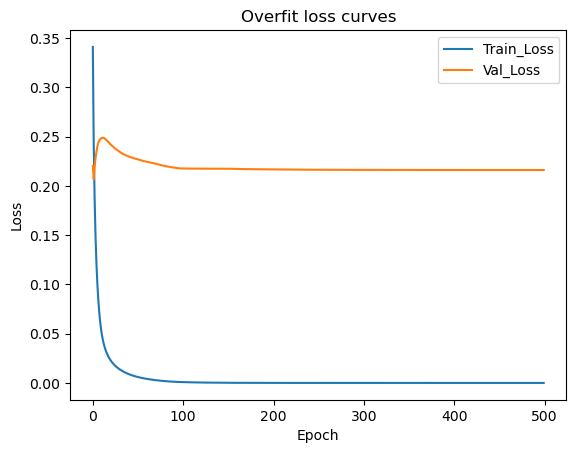

In [21]:
train_loss = FFNN_overfit.getEpochTL()
val_loss = FFNN_overfit.getEpochVL()
train_loss_df = pd.DataFrame(list(train_loss.items()), columns=["Epoch", "Train_Loss"])
val_loss_df = pd.DataFrame(list(val_loss.items()), columns=["Epoch", "Val_Loss"])
loss_df = train_loss_df.merge(val_loss_df, on="Epoch")
loss_df.plot(x="Epoch", y=["Train_Loss","Val_Loss"], kind="line",ylabel="Loss", title="Overfit loss curves")

<Axes: title={'center': 'Train and Validation Loss over Epochs'}, xlabel='Epoch', ylabel='Loss'>

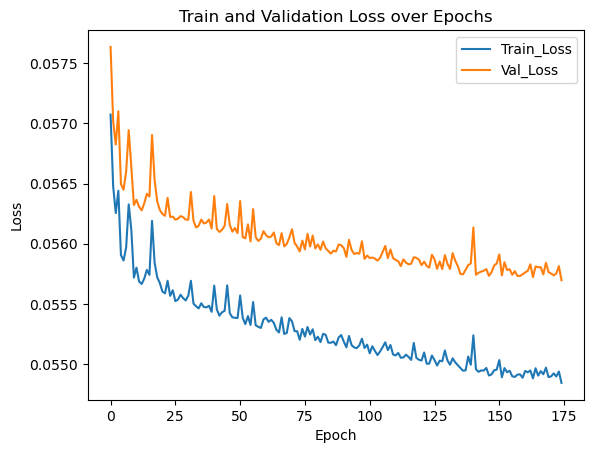

In [22]:
train_loss = FFNN.getEpochTL()
val_loss = FFNN.getEpochVL()
train_loss_df = pd.DataFrame(list(train_loss.items()), columns=["Epoch", "Train_Loss"])
val_loss_df = pd.DataFrame(list(val_loss.items()), columns=["Epoch", "Val_Loss"])
loss_df = train_loss_df.merge(val_loss_df, on="Epoch")
loss_df.plot(x="Epoch", y=["Train_Loss","Val_Loss"], kind="line",ylabel="Loss", title="Train and Validation Loss over Epochs")

In [164]:
y_pred_normal = FFNN.predict(X_test_scaled)


In [170]:
r2 = r2_score(y_test, y_pred_normal)
np.round(r2,4)

0.0268

In [166]:
np.max(y_pred_normal)

0.9122642655082994

In [167]:
mean_absolute_error(y_test, y_pred_normal)

0.09836644060464068

-----------------------------------------------------------------------------------------------------------------------------
***Cross validation & Grid Search***

In [ ]:
df3 = pd.read_csv(R"data\final_train_data.csv")
df4 = pd.read_csv(R"feature_engineered.csv")
df3["ClaimNb"] = df4["ClaimNb"]
target = "ClaimNb"
cols = [target] + [col for col in df3.columns if col != target]
k = df3[cols]
df = df[cols]
#df = pd.get_dummies(df, drop_first=True, dtype="int")
k.to_csv(R"C:\Users\Simon\Desktop\Project ML\ML-project\data\final_train_data.csv", index=False)

k

,ClaimNb,BonusMalus,Exposure,VehAge,VehBrand_B12,DrivAge,VehPower,VehGas_Regular,Density
0,0,95,0.43,18,0,36,7,1,1054
1,0,95,0.10,17,0,80,7,1,598
2,0,76,0.33,3,0,36,7,1,4172
3,0,52,0.56,4,0,73,5,0,15
4,0,50,0.27,0,0,37,8,0,3021
...,...,...,...,...,...,...,...,...,...
541411,0,76,0.20,10,0,32,6,0,1314
541412,0,60,0.06,14,0,34,10,0,685
541413,0,95,0.34,8,0,32,6,0,242
541414,0,72,0.72,7,0,39,9,1,3301


In [185]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


X_scaled = scaler.fit_transform(X)

In [168]:
X_len = len(X.columns)

In [ ]:
num_folds = 5
patiences = [10,15,20,25,30]
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
p_results = {}

for p in patiences:
    print(f"Testing learning rate: {p}")

    model = NeuralNetworkWrapper(
        input_size=X_len,
        hidden_layers=[100, 50, 20],
        patience=p,
        mini_batch_size=42,
        epochs=175,
        learning_rate=0.009 
    )
    #model.fit(X_train_scaled,y_train)
    cv_scores = cross_val_score(model,X_scaled,y,cv=kf)
    p_results[p] = {
        'scores': cv_scores,
        'mean_score': cv_scores.mean(),
        'std_dev': cv_scores.std()
    }
    print(f"  Mean Score: {p_results[p]['mean_score']:.4f}, Std Dev: {p_results[p]['std_dev']:.4f}\n")

Testing learning rate: 10
Starting training with Early Stopping (Patience: 10)...
Epoch 0/175, Train Loss: 0.057090, Val Loss: 0.054425
Epoch 50/175, Train Loss: 0.056080, Val Loss: 0.053659

--- Early Stopping Triggered! ---
Validation loss did not improve for 10 epochs.
Best Validation Loss: 0.053503 (Restoring weights)
Starting training with Early Stopping (Patience: 10)...
Epoch 0/175, Train Loss: 0.056229, Val Loss: 0.055433
Epoch 50/175, Train Loss: 0.055230, Val Loss: 0.054668

--- Early Stopping Triggered! ---
Validation loss did not improve for 10 epochs.
Best Validation Loss: 0.054563 (Restoring weights)
Starting training with Early Stopping (Patience: 10)...
Epoch 0/175, Train Loss: 0.056328, Val Loss: 0.057089
Epoch 50/175, Train Loss: 0.055107, Val Loss: 0.055943

--- Early Stopping Triggered! ---
Validation loss did not improve for 10 epochs.
Best Validation Loss: 0.055907 (Restoring weights)
Starting training with Early Stopping (Patience: 10)...
Epoch 0/175, Train Loss:

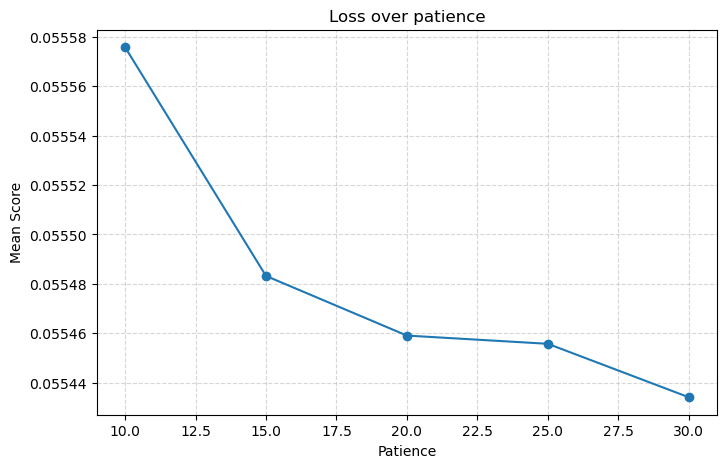

In [132]:
mean_scores_p = np.array([-v['mean_score'] for v in p_results.values()])
plt.figure(figsize=(8,5))

plt.plot(patiences,mean_scores_p, marker="o")



plt.xlabel("Patience")
plt.ylabel("Mean Score")
plt.title("Loss over patience")

plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()


In [ ]:
num_folds = 5
learning_rates = [0.01,0.005,0.001]
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
results = {}

for lr in learning_rates:
    print(f"Testing learning rate: {lr}")

    model = NeuralNetworkWrapper(
        input_size=len(X.columns),
        hidden_layers=[100, 50, 20],
        mini_batch_size=32,
        epochs=25,
        learning_rate=lr # The hyperparameter being tested
    )
    #model.fit(X_train_scaled,y_train)
    cv_scores = cross_val_score(model,X_scaled,y,cv=kf)
    results[lr] = {
        'scores': cv_scores,
        'mean_score': cv_scores.mean(),
        'std_dev': cv_scores.std()
    }
    print(f"  Mean Score: {results[lr]['mean_score']:.4f}, Std Dev: {results[lr]['std_dev']:.4f}\n")

Testing learning rate: 0.01
Epoch 0, Batch Loss: 0.003188
Epoch 0, Batch Loss: 0.001099
Epoch 0, Batch Loss: 0.001278
Epoch 0, Batch Loss: 0.003326
Epoch 0, Batch Loss: 0.005900
  Mean Score: -0.0558, Std Dev: 0.0013

Testing learning rate: 0.005
Epoch 0, Batch Loss: 0.004610
Epoch 0, Batch Loss: 0.002136
Epoch 0, Batch Loss: 0.002599
Epoch 0, Batch Loss: 0.004455
Epoch 0, Batch Loss: 0.007489
  Mean Score: -0.0559, Std Dev: 0.0013

Testing learning rate: 0.001
Epoch 0, Batch Loss: 0.012370
Epoch 0, Batch Loss: 0.007062
Epoch 0, Batch Loss: 0.002765
Epoch 0, Batch Loss: 0.013858
Epoch 0, Batch Loss: 0.018540
  Mean Score: -0.0560, Std Dev: 0.0013



**Batch normalization loss, CV, learning rates.**

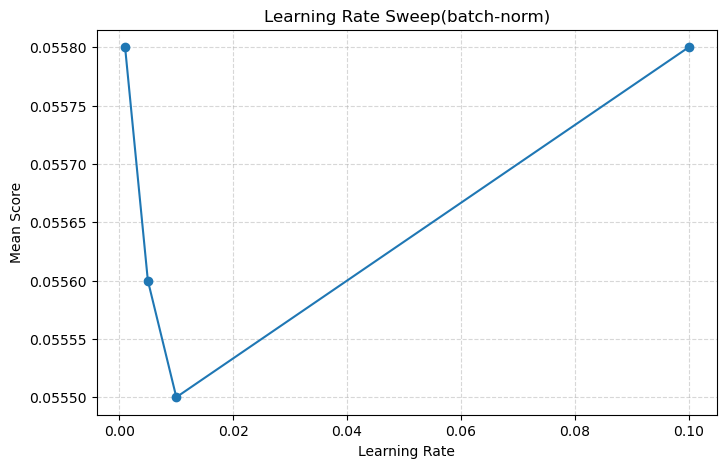

In [86]:
lrs = np.array([0.1, 0.01,0.005, 0.001])
#Batch norm scores for the different learning rates.
mean_scores = np.array([-0.0558, -0.0555, -0.0556, -0.0558])
std_scores = np.array([0.0013, 0.0010, 0.0011, 0.0012])

plt.figure(figsize=(8,5))
plt.plot(lrs,-mean_scores, marker="o")



plt.xlabel("Learning Rate")
plt.ylabel("Mean Score")
plt.title("Learning Rate Sweep(batch-norm)")

plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

**FFNN loss in CV, for learning rates. Didnt include 0.10 because it exploded**

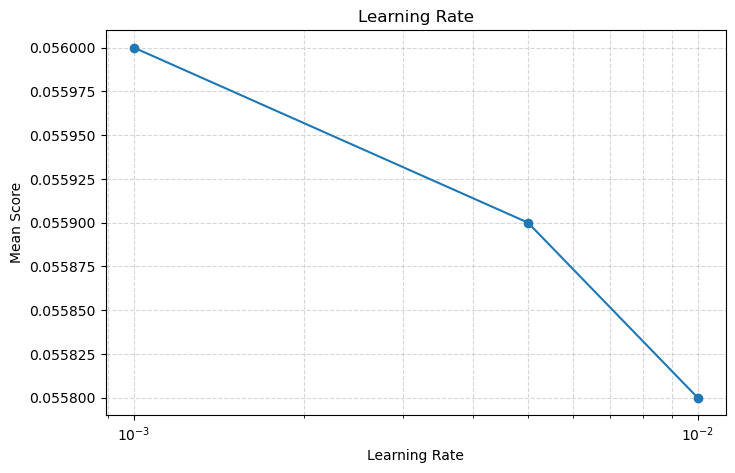

In [201]:
lrs_ffnn = [0.01,0.005,0.001]
mean_scores_ffnn = [0.0558,0.0559,0.0560]

plt.figure(figsize=(8,5))


plt.plot(lrs_ffnn,mean_scores_ffnn, marker="o")
plt.xscale('log')

plt.xlabel("Learning Rate")
plt.ylabel("Mean Score")
plt.title("Learning Rate")

plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

In [ ]:
num_folds = 5
epochs = [10,25,50,100,200,400]
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
result_epoch = {}

for epoch in epochs:
    print(f"Testing epoch: {epoch}")

    model = NeuralNetworkWrapper(
        input_size=X_len, 
        hidden_layers=[100, 50, 20],
        mini_batch_size=32,
        epochs=epoch,
        learning_rate=0.01 
    )
    model.fit(X_train_scaled,y_train)
    cv_scores = cross_val_score(model,X_scaled,y,cv=kf)
    result_epoch[epoch] = {
        'scores': cv_scores,
        'mean_score': cv_scores.mean(),
        'std_dev': cv_scores.std()
    }
    print(f"  Mean Score: {result_epoch[epoch]['mean_score']:.4f}, Std Dev: {result_epoch[epoch]['std_dev']:.4f}\n")

Testing epoch: 10
Epoch 0 | Train Loss: 0.056174
Epoch 0 | Train Loss: 0.056168
Epoch 0 | Train Loss: 0.056949
Epoch 0 | Train Loss: 0.055955
Epoch 0 | Train Loss: 0.056669
Epoch 0 | Train Loss: 0.056031
  Mean Score: -0.0563, Std Dev: 0.0014

Testing epoch: 25
Epoch 0 | Train Loss: 0.056146
Epoch 0 | Train Loss: 0.056258
Epoch 0 | Train Loss: 0.056893
Epoch 0 | Train Loss: 0.055881
Epoch 0 | Train Loss: 0.056552
Epoch 0 | Train Loss: 0.055997
  Mean Score: -0.0562, Std Dev: 0.0013

Testing epoch: 50
Epoch 0 | Train Loss: 0.056016
Epoch 0 | Train Loss: 0.056224
Epoch 0 | Train Loss: 0.056887
Epoch 0 | Train Loss: 0.055835
Epoch 0 | Train Loss: 0.056594
Epoch 0 | Train Loss: 0.056038
  Mean Score: -0.0559, Std Dev: 0.0013

Testing epoch: 100
Epoch 0 | Train Loss: 0.056154
Epoch 50 | Train Loss: 0.055679
Epoch 0 | Train Loss: 0.056063
Epoch 50 | Train Loss: 0.055656
Epoch 0 | Train Loss: 0.057151
Epoch 50 | Train Loss: 0.056266
Epoch 0 | Train Loss: 0.055913
Epoch 50 | Train Loss: 0.0553

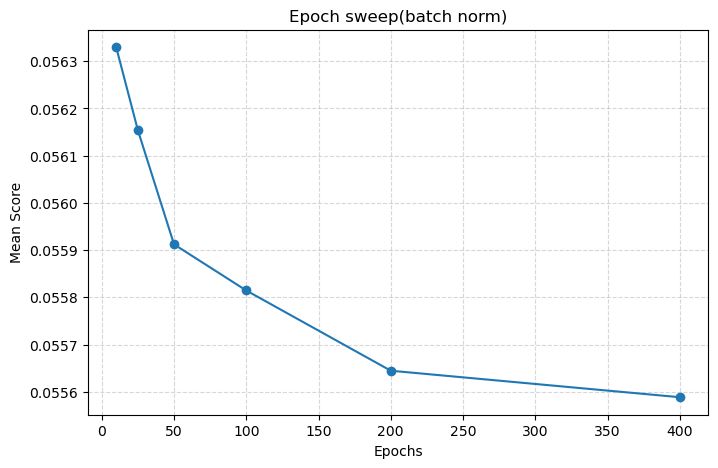

In [93]:
epochs = [10,25,50,100,200,400]
all_mean_scores_epoch = [result_epoch[e]['mean_score'] for e in result_epoch]
real_mse_scores = [-v['mean_score'] for v in result_epoch.values()]
plt.figure(figsize=(8,5))

plt.plot(epochs,real_mse_scores, marker="o")

plt.xlabel("Epochs")
plt.ylabel("Mean Score")
plt.title("Epoch sweep(batch norm)")

plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

In [ ]:
num_folds = 5
epochs = [10,25,50,100,200,400]
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
result_epoch_ffnn = {}

for epoch in epochs:
    print(f"Testing epoch: {epoch}")

    model = NeuralNetworkWrapper(
        input_size=X_len, 
        hidden_layers=[100, 50, 20],
        mini_batch_size=32,
        epochs=epoch,
        learning_rate=0.01 
    )
    model.fit(X_train_scaled,y_train)
    cv_scores = cross_val_score(model,X_scaled,y,cv=kf)
    result_epoch_ffnn[epoch] = {
        'scores': cv_scores,
        'mean_score': cv_scores.mean(),
        'std_dev': cv_scores.std()
    }
    print(f"  Mean Score: {result_epoch[epoch]['mean_score']:.4f}, Std Dev: {result_epoch[epoch]['std_dev']:.4f}\n")

Testing epoch: 10
Epoch 0, Batch Loss: 0.306642
Epoch 0, Batch Loss: 0.003188
Epoch 0, Batch Loss: 0.001099
Epoch 0, Batch Loss: 0.001278
Epoch 0, Batch Loss: 0.003326
Epoch 0, Batch Loss: 0.005900
  Mean Score: -0.0563, Std Dev: 0.0014

Testing epoch: 25
Epoch 0, Batch Loss: 0.306642
Epoch 0, Batch Loss: 0.003188
Epoch 0, Batch Loss: 0.001099
Epoch 0, Batch Loss: 0.001278
Epoch 0, Batch Loss: 0.003326
Epoch 0, Batch Loss: 0.005900
  Mean Score: -0.0562, Std Dev: 0.0013

Testing epoch: 50
Epoch 0, Batch Loss: 0.306642
Epoch 0, Batch Loss: 0.003188
Epoch 0, Batch Loss: 0.001099
Epoch 0, Batch Loss: 0.001278
Epoch 0, Batch Loss: 0.003326
Epoch 0, Batch Loss: 0.005900
  Mean Score: -0.0559, Std Dev: 0.0013

Testing epoch: 100
Epoch 0, Batch Loss: 0.306642
Epoch 0, Batch Loss: 0.003188
Epoch 0, Batch Loss: 0.001099
Epoch 0, Batch Loss: 0.001278
Epoch 0, Batch Loss: 0.003326
Epoch 0, Batch Loss: 0.005900
  Mean Score: -0.0558, Std Dev: 0.0013

Testing epoch: 200
Epoch 0, Batch Loss: 0.30664

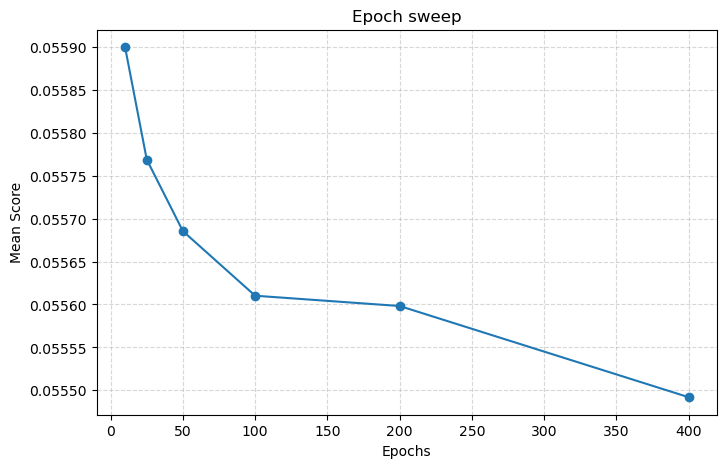

In [216]:
epochs = [10,25,50,100,200,400]
all_mean_scores_epoch = [result_epoch_ffnn[e]['mean_score'] for e in result_epoch_ffnn]
real_mse_scores = [-v['mean_score'] for v in result_epoch_ffnn.values()]
plt.figure(figsize=(8,5))

plt.plot(epochs,real_mse_scores, marker="o")

plt.xlabel("Epochs")
plt.ylabel("Mean Score")
plt.title("Epoch sweep")

plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

In [ ]:
num_folds = 5
mini_batch = [32,64,128,256]
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
mb_ffnn = {}

for mb in mini_batch:
    print(f"Testing mb: {mb}")

    model = NeuralNetworkWrapper(
        input_size=X_scaled, # Assuming this is the correct input size
        hidden_layers=[100, 50, 20],
        mini_batch_size=mb,
        epochs=400,
        learning_rate=0.01 # The hyperparameter being tested
    )
    model.fit(X_train_scaled,y_train)
    cv_scores = cross_val_score(model,X_scaled,y,cv=kf)
    mb_ffnn[mb] = {
        'scores': cv_scores,
        'mean_score': cv_scores.mean(),
        'std_dev': cv_scores.std()
    }
    print(f"  Mean Score: {mb_ffnn[mb]['mean_score']:.4f}, Std Dev: {mb_ffnn[mb]['std_dev']:.4f}\n")

Testing mb: 32
Epoch 0, Batch Loss: 0.306642
Epoch 100, Batch Loss: 0.002708
Epoch 200, Batch Loss: 0.042102
Epoch 300, Batch Loss: 0.074954
Epoch 0, Batch Loss: 0.003188
Epoch 100, Batch Loss: 0.008688
Epoch 200, Batch Loss: 0.096242
Epoch 300, Batch Loss: 0.005572
Epoch 0, Batch Loss: 0.001099
Epoch 100, Batch Loss: 0.117690
Epoch 200, Batch Loss: 0.007785
Epoch 300, Batch Loss: 0.576374
Epoch 0, Batch Loss: 0.001278
Epoch 100, Batch Loss: 0.008965
Epoch 200, Batch Loss: 0.108629
Epoch 300, Batch Loss: 0.116391
Epoch 0, Batch Loss: 0.003326
Epoch 100, Batch Loss: 0.001523
Epoch 200, Batch Loss: 0.006464
Epoch 300, Batch Loss: 0.009954
Epoch 0, Batch Loss: 0.005900
Epoch 100, Batch Loss: 0.003176
Epoch 200, Batch Loss: 0.005998
Epoch 300, Batch Loss: 0.126217
  Mean Score: -0.0555, Std Dev: 0.0013

Testing mb: 64
Epoch 0, Batch Loss: 0.286461
Epoch 100, Batch Loss: 0.002405
Epoch 200, Batch Loss: 0.043195
Epoch 300, Batch Loss: 0.077524
Epoch 0, Batch Loss: 0.004372
Epoch 100, Batch L

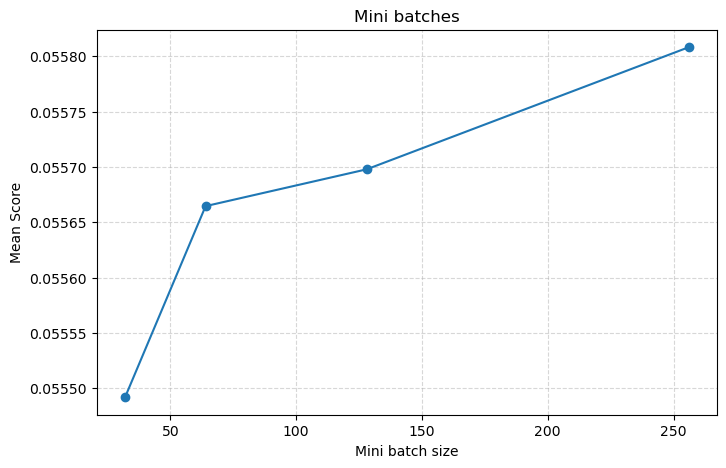

In [ ]:
mini_batch = [32,64,128,256]
mean_scores_MB = np.array([-v['mean_score'] for v in mb_ffnn.values()])
plt.figure(figsize=(8,5))

plt.plot(mini_batch,mean_scores_MB, marker="o")



plt.xlabel("Mini batch size")
plt.ylabel("Mean Score")
plt.title("Mini batches")

plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()


Best LR:0.001; best epoch:400, but we use 200; best mb:32.

For every CV we used an arbitary number of hidden layers and neurons. This might be differnet now doing gridsearch.

In [102]:
param_grid = {
    'hidden_layers': [
        [200, 100, 50], 
        [100,50], 
        [100, 50, 20],
        [80,60,40,20]
    ],
    'learning_rate': [0.001,0.003,0.005,0.009],
    'mini_batch_size': [32, 42,52,62],
    'epochs': [175,200,225,250,275,300]
}

In [ ]:
""" Made with LLM, as we needed to modify some of the class to make it work 100% 
Using R2 for scoing.
"""
nn_wrapper = NeuralNetworkWrapper(input_size=X_len)

# Gridsearch CV NOT stratified
grid_search = GridSearchCV(
    estimator=nn_wrapper,
    param_grid=param_grid,
    scoring='r2', # Or 'r2' for regression
    cv=3,                             # Number of cross-validation folds
    n_jobs=5,                        #n cores used.
    verbose=2,
    return_train_score=True
)


#X_train_scaled and y_train must be numpy arrays
print("Starting Grid Search...")
grid_search.fit(X_scaled, y)

#Get results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

# You can now use the best model directly
best_model = grid_search.best_estimator_
#predictions = best_model.predict()


Starting Grid Search...
Fitting 3 folds for each of 384 candidates, totalling 1152 fits
Starting training with Early Stopping (Patience: 10)...
Starting training with Early Stopping (Patience: 10)...
Starting training with Early Stopping (Patience: 10)...
Starting training with Early Stopping (Patience: 10)...
Starting training with Early Stopping (Patience: 10)...
Epoch 0/175, Train Loss: 0.062461, Val Loss: 0.062666
Epoch 0/175, Train Loss: 0.063231, Val Loss: 0.061201
Epoch 0/175, Train Loss: 0.061376, Val Loss: 0.061602
Epoch 0/175, Train Loss: 0.062145, Val Loss: 0.060068
Epoch 0/175, Train Loss: 0.061462, Val Loss: 0.059651
Epoch 50/175, Train Loss: 0.055607, Val Loss: 0.056039
Epoch 50/175, Train Loss: 0.056255, Val Loss: 0.054330
Epoch 50/175, Train Loss: 0.056186, Val Loss: 0.054276
Epoch 50/175, Train Loss: 0.055669, Val Loss: 0.053945
Epoch 50/175, Train Loss: 0.055552, Val Loss: 0.055993

--- Early Stopping Triggered! ---
Validation loss did not improve for 10 epochs.
Best 

/opt/anaconda3/envs/ml/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Starting training with Early Stopping (Patience: 10)...
Epoch 0/175, Train Loss: 0.058556, Val Loss: 0.058914
Epoch 100/175, Train Loss: 0.055528, Val Loss: 0.055950

--- Early Stopping Triggered! ---
Validation loss did not improve for 10 epochs.
Best Validation Loss: 0.055762 (Restoring weights)
Epoch 100/175, Train Loss: 0.055689, Val Loss: 0.053983
[CV] END epochs=175, hidden_layers=[200, 100, 50], learning_rate=0.003, mini_batch_size=32; total time= 6.2min
Starting training with Early Stopping (Patience: 10)...
Epoch 0/175, Train Loss: 0.058948, Val Loss: 0.057215

--- Early Stopping Triggered! ---
Validation loss did not improve for 10 epochs.
Best Validation Loss: 0.053867 (Restoring weights)
[CV] END epochs=175, hidden_layers=[200, 100, 50], learning_rate=0.001, mini_batch_size=62; total time= 8.4min
Starting training with Early Stopping (Patience: 10)...
Epoch 0/175, Train Loss: 0.061271, Val Loss: 0.059246

--- Early Stopping Triggered! ---
Validation loss did not improve for

Best Parameters: {'epochs': 400, 'hidden_layers': [100, 50, 20], 'learning_rate': 0.01, 'mini_batch_size': 64}
Best Score: 0.022957925930353878 For **batch normalization**


Best Parameters: {'epochs': 175, 'hidden_layers': [100, 50, 20], 'learning_rate': 0.009, 'mini_batch_size': 42}
Best Score: 0.02364311025484696

mean_fit_time                                                   139.175428
std_fit_time                                                     35.622622
mean_score_time                                                   0.213025
std_score_time                                                    0.008065
param_epochs                                                           175
param_hidden_layers                                          [100, 50, 20]
param_learning_rate                                                  0.009
param_mini_batch_size                                                   42
params                   {'epochs': 175, 'hidden_layers': [100, 50, 20]...
split0_test_score                                                 0.023599
split1_test_score                                                 0.021629
split2_test_score                                                 0.025701
mean_test_score                                                   0.023643
std_test_score           

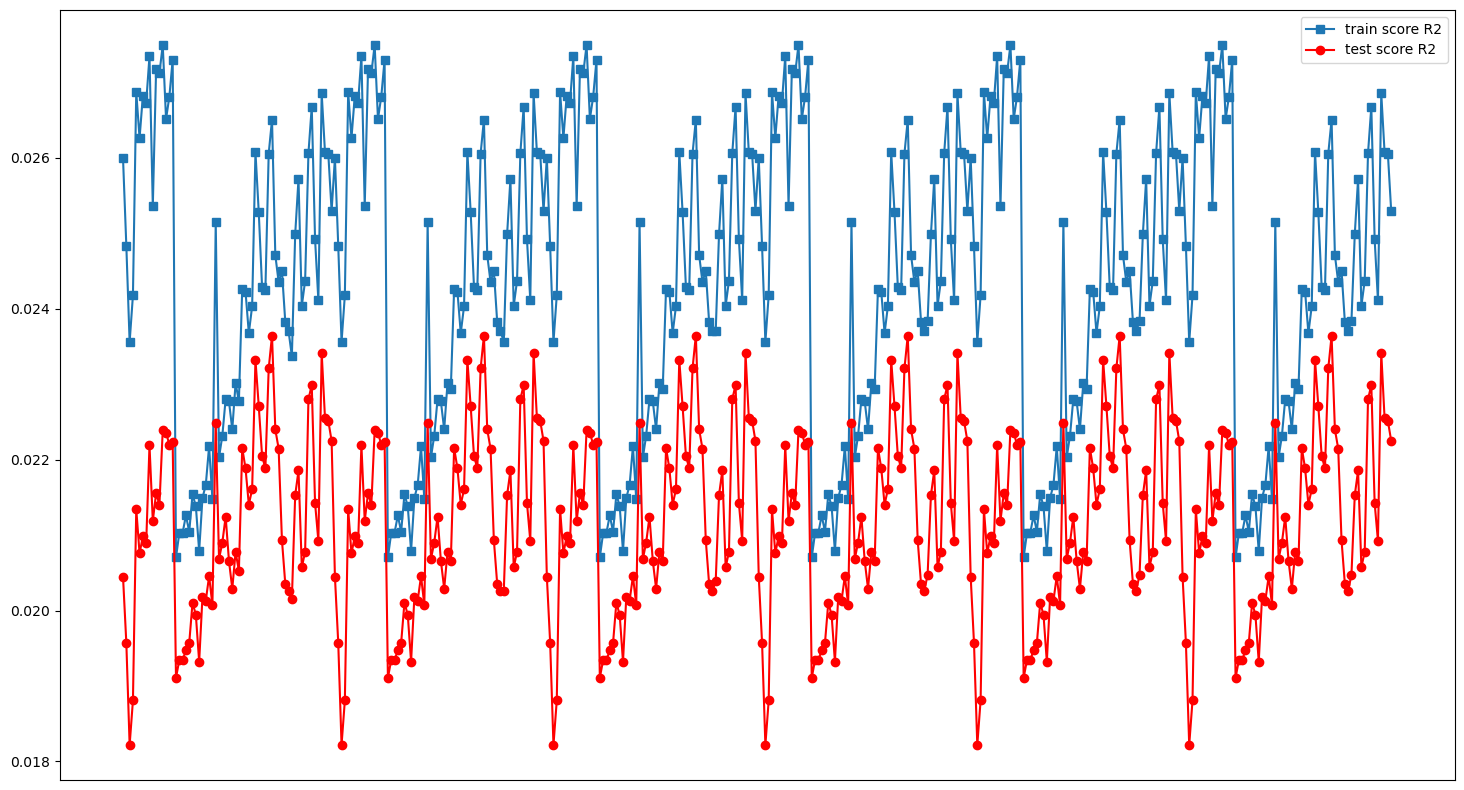

In [144]:
results = pd.DataFrame(grid_search.cv_results_)

# Expand the 'params' dict into separate columns
results["ID"] = (results.index + 1).astype(str)
results
X_axis_val = results["ID"]
Y_axis_val_train = results["mean_train_score"]
Y_axis_val_test = results["mean_test_score"]
plt.figure(figsize=(18, 10))
plt.plot(X_axis_val,Y_axis_val_train,label="train score R2",marker="s")
plt.plot(X_axis_val,Y_axis_val_test,label="test score R2",marker="o",color="Red")
plt.xticks([])
plt.legend()
best_score = np.argmax(Y_axis_val_test)
results.iloc[best_score]


I really dont know why there is a pattern of error. I would guess it has something to do with how the data is distributed in the folds.
But I really dont know

Ah! it might be because I used seed in fit()...... :( Should still be some way valid! :D

In [107]:
test_df = pd.read_csv(R"data/claims_test.csv")
test_df = test_df[test_df["Exposure"] <= 1].copy()
test_df["Exposure"].max()
test_df

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1135885,0,1.00,E,5,8,46,50,B1,Regular,4116,R24
1,51280,0,0.24,D,4,10,46,64,B1,Regular,1329,R11
2,6112464,0,0.41,C,4,0,32,72,B12,Regular,377,R73
3,3245787,0,0.07,C,5,4,57,50,B2,Diesel,251,R93
4,168150,0,0.06,B,4,10,45,50,B2,Regular,94,R53
...,...,...,...,...,...,...,...,...,...,...,...,...
135598,2118590,0,0.35,D,10,6,57,85,B12,Diesel,879,R82
135599,3020007,0,0.87,D,10,10,46,56,B5,Diesel,1609,R11
135600,1089081,0,1.00,E,8,8,35,50,B5,Regular,3744,R93
135601,6104970,0,0.50,E,11,1,32,54,B12,Regular,6485,R11


In [ ]:
test_df = pd.read_csv(R"data\processed_test_data.csv")
test_df = pd.get_dummies(test_df, drop_first=True, dtype="int")
test_df.to_csv(R"processed_test_data.csv", index=False)

**Training the model on traing data and predicting on test data**

In [ ]:
df_train = pd.read_csv(R"data\final_train_data.csv")
df1_train = pd.read_csv(R"data\optimized_engineered.csv")
df_test = pd.read_csv(R"data\processed_test_data.csv")
df_test

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,VehBrand_B12,VehGas_Regular
0,0,1.00,5,8,46,50,4116,0,1
1,0,0.24,4,10,46,64,1329,0,1
2,0,0.41,4,0,32,72,377,1,1
3,0,0.07,5,4,57,50,251,0,0
4,0,0.06,4,10,45,50,94,0,1
...,...,...,...,...,...,...,...,...,...
135368,0,0.35,10,6,57,85,879,1,0
135369,0,0.87,10,10,46,56,1609,0,0
135370,0,1.00,8,8,35,50,3744,0,1
135371,0,0.50,11,1,32,54,6485,1,1


In [145]:
features = ["BonusMalus", "Exposure", "VehAge", "VehBrand_B12", "DrivAge", "VehPower", "VehGas_Regular", "Density"]

In [203]:
#define X train and test, y train and test. Scale X train and fit X test
y_train = df_train["ClaimNb"]
X_train = df_train[features]

y_test = df_test["ClaimNb"]
X_test = df_test[features]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  
X_test_scaled = scaler.transform(X_test)


In [204]:
X_test

,BonusMalus,Exposure,VehAge,VehBrand_B12,DrivAge,VehPower,VehGas_Regular,Density
0,50,1.00,8,0,46,5,1,4116
1,64,0.24,10,0,46,4,1,1329
2,72,0.41,0,1,32,4,1,377
3,50,0.07,4,0,57,5,0,251
4,50,0.06,10,0,45,4,1,94
...,...,...,...,...,...,...,...,...
135368,85,0.35,6,1,57,10,0,879
135369,56,0.87,10,0,46,10,0,1609
135370,50,1.00,8,0,35,8,1,3744
135371,54,0.50,1,1,32,11,1,6485


In [208]:
X_train

,BonusMalus,Exposure,VehAge,VehBrand_B12,DrivAge,VehPower,VehGas_Regular,Density
0,95,0.43,18,0,36,7,1,1054
1,95,0.10,17,0,80,7,1,598
2,76,0.33,3,0,36,7,1,4172
3,52,0.56,4,0,73,5,0,15
4,50,0.27,0,0,37,8,0,3021
...,...,...,...,...,...,...,...,...
541411,76,0.20,10,0,32,6,0,1314
541412,60,0.06,14,0,34,10,0,685
541413,95,0.34,8,0,32,6,0,242
541414,72,0.72,7,0,39,9,1,3301


In [209]:
FFNN_final = FFNN_regressor(input_size=len(X_train.columns), hidden_layers=[100,50,20],seed=42)

In [210]:
FFNN_final.train_batch(X_train_scaled,y_train, mini_batch_size=42,epochs=175, learning_rate=0.009, patience=20)

Starting training with Early Stopping (Patience: 20)...
Epoch 0/175, Train Loss: 0.057224, Val Loss: 0.057497
Epoch 50/175, Train Loss: 0.055432, Val Loss: 0.055908
Epoch 100/175, Train Loss: 0.055211, Val Loss: 0.055804
Epoch 150/175, Train Loss: 0.054989, Val Loss: 0.055695
Epoch 174/175, Train Loss: 0.055049, Val Loss: 0.055753
Completed all epochs. Restoring best weights found during training.


(0.055048960064467245, 0.05561438785548852, 175)

In [211]:
y_pred = FFNN_final.predict(X_test_scaled)

In [213]:
MSE = mean_squared_error(y_test,y_pred)
R2 = r2_score(y_test,y_pred)

In [214]:
MSE, R2

(0.058400487376717346, 0.030174153659821235)